# Regression with Probabilistic Layers in TensorFlow Probability

An up to-date version of [Regression with Probabilistic Layers in TensorFlow Probability](https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf). Working code also exists in this [colab](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb#scrollTo=Fp4qEWSRzc8m).

The code below is just the imports and creating the dataset.

In [1]:
!pip install tensorflow==1.14

ERROR: Could not find a version that satisfies the requirement tensorflow==1.14 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==1.14


In [2]:
# computational
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

# functional programming
from functools import partial

# plotting
import matplotlib.pyplot as plt

# plot utilities
%matplotlib inline
plt.style.use('ggplot')
def plt_left_title(title): plt.title(title, loc="left", fontsize=18)
def plt_right_title(title): plt.title(title, loc='right', fontsize=13, color='grey')


# aliases
import tf_keras as tfk
tfd = tfp.distributions

print(f"            tensorflow version: {tf.__version__}")
print(f"tensorflow probability version: {tfp.__version__}")

2025-01-20 13:31:37.332022: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 13:31:37.352750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


            tensorflow version: 2.16.1
tensorflow probability version: 0.24.0


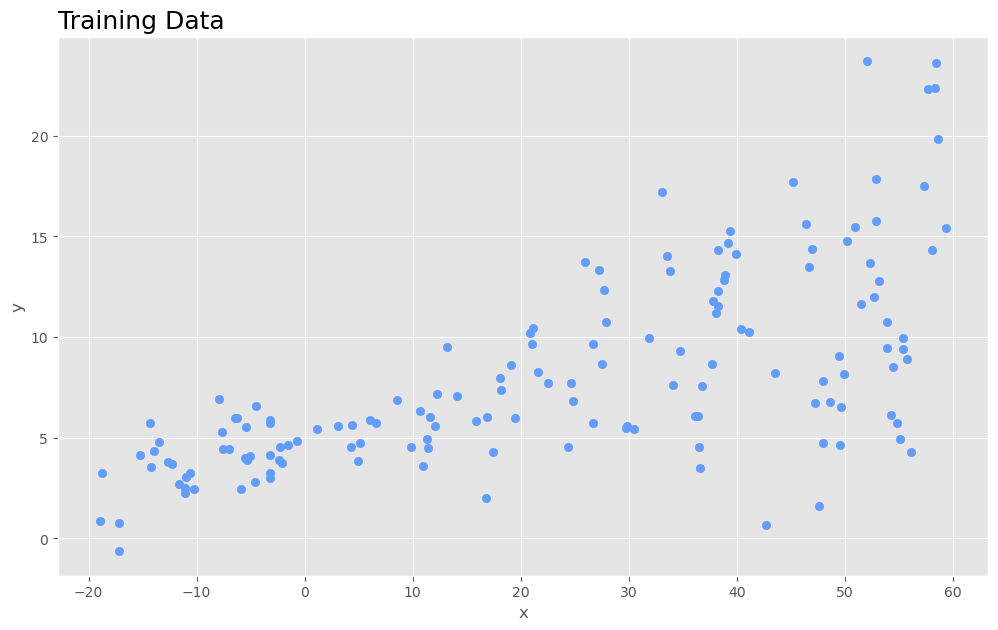

In [3]:
# create sample dataset
w0, b0 = 0.125, 5.0

n_samples = 150

x_range = [-20, 60]
x_domain = np.linspace(*x_range, n_samples)

def load_dataset(n=150, n_tst=n_samples):
    np.random.seed(27)
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst

ys, xs, xs_test = load_dataset()

def plot_training_data(): 
    plt.figure(figsize=(12, 7))
    plt.scatter(xs, ys, c="#619CFF", label="training data")
    plt.xlabel("x")
    plt.ylabel("y")

plot_training_data()
plt_left_title("Training Data");

# Case 1: Simple Linear Regression

The model below is a linear regression model written as a Neural Network with:

- one-dimensional input (the `xs` data)
- a hidden layer with one node, and bias
- an output layer that is a Normal distribution with constant variance

By training the Neural Network, we are finding the weights $w_0$ and $b_0$ such that

$$
f(x) \sim N(w_0 x + b_0, 1)
$$

So the model outputs a distribution, rather than a number. We find these weights in the usual way, by minimizing a loss function. For this model, and all upcoming models, the loss is the negative log-likelihood of the output distribution. 

Tensorflow Probability Distributions have a `log_prob` method, so that's what we'll use.

![](http://)We fit the model below.

In [4]:
def neg_log_lik(y, rv_y):
    """Evaluate negative log-likelihood of a random variable `rv_y` for data `y`"""
    return -rv_y.log_prob(y)

In [6]:
# model outputs normal distribution with constant variance
model_case_1 = tfk.Sequential([
    tfk.layers.Dense(1),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t, scale=1.0)
    )
])

# train the model
model_case_1.compile(optimizer=tfk.optimizers.Adam(learning_rate=0.01), 
                    loss=neg_log_lik)
model_case_1.fit(xs, ys, 
                 epochs=500,
                 verbose=False)

print(f"predicted w : {model_case_1.layers[-2].kernel.numpy()}")
print(f"predicted b : {model_case_1.layers[-2].bias.numpy()}")

I0000 00:00:1737379913.180182  532116 service.cc:145] XLA service 0x78b209394e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737379913.180196  532116 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-01-20 13:31:53.182863: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-20 13:31:53.189132: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1737379913.220729  532116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


predicted w : [[0.13971207]]
predicted b : [4.7149234]


Recall that this model outputs a distribution for any input `x`. In this case, the mean of the distribution for any input `x` is $w_0 x + b_0$. That's the equation for a line, so we should expect to see a straight line when we plot the model's mean predictions of each `x` in our test set.

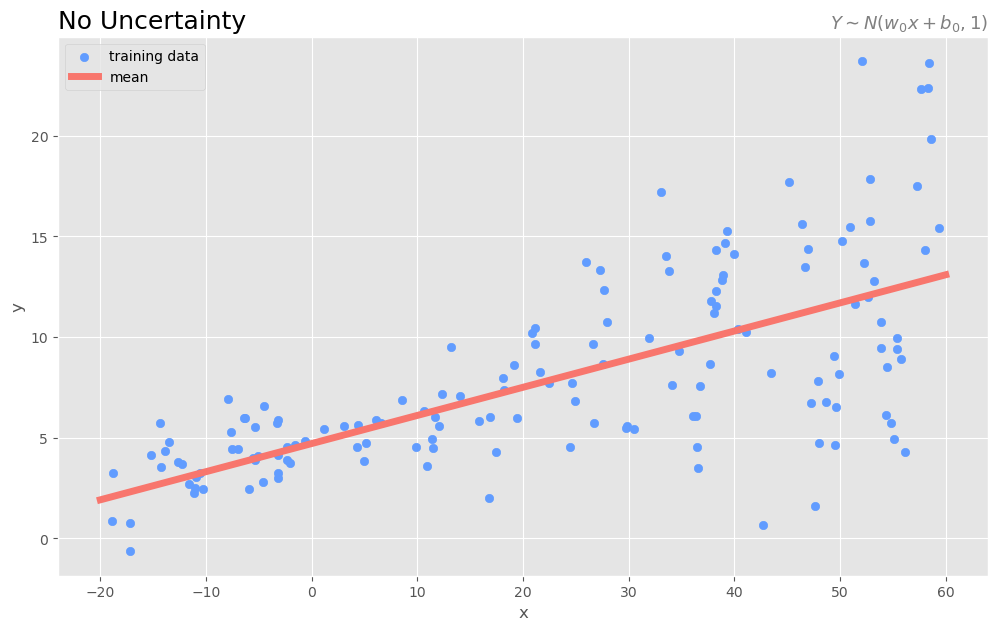

In [7]:
# predict xs
yhat = model_case_1(xs_test)

plot_training_data()
plt_left_title("No Uncertainty")
plt_right_title("$Y \sim N(w_0 x + b_0, 1)$")
# plot predicted means for each x
plt.plot(x_domain, yhat.mean(), "#F8766D", linewidth=5, label="mean")
plt.legend();

# Case 2: Aleatoric Uncertainty

Notice from the training data that:

- There is variability in the $y$ for any particular value of $x$
- The variance of $y$ seems to be related to $x$ (e.g. it increases as $x$ does)

Now we're constructing a model that has:

- one-dimensional input
- a hidden layer with two nodes
- an output layer that yields a Normal distribution with non-constant variance

In this case, our model is more complex:

$$
f(x) \sim N(\mu (x), \sigma(x))
$$

* Where $\mu$ is a linear function, and $\sigma$ is a [softplus function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks). Once again, we use negative log-likelihood as our loss function.

In [8]:
def normal_scale_uncertainty(t, softplus_scale=0.05):
    """Create distribution with variable mean and variance"""
    ts = t[..., :1]
    return tfd.Normal(loc = ts,
                      scale = 1e-3 + tf.math.softplus(softplus_scale * ts))

In [9]:
# model outputs normal distribution with mean and variance that 
# depend on the input
model_case_2 = tfk.Sequential([
    tfk.layers.Dense(2),
    tfp.layers.DistributionLambda(normal_scale_uncertainty)
])

model_case_2.compile(optimizer=tfk.optimizers.Adam(learning_rate=0.05),
                    loss=neg_log_lik)
model_case_2.fit(xs, ys,
                epochs=500,
                verbose=False)

print("Model 2 weights:")
[print(np.squeeze(w.numpy())) for w in model_case_2.weights];

Model 2 weights:
[ 0.14099288 -1.1964947 ]
[4.975456 0.      ]


The plot below suggests a linear relationship between $x$ and $y$, but it shows that as $x$ gets larger, there is more variance in the prediction $y$. 

This is called [**aleatoric uncertainty**](https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic_uncertainty), which refers to the unknowns that differ each time data is collected.

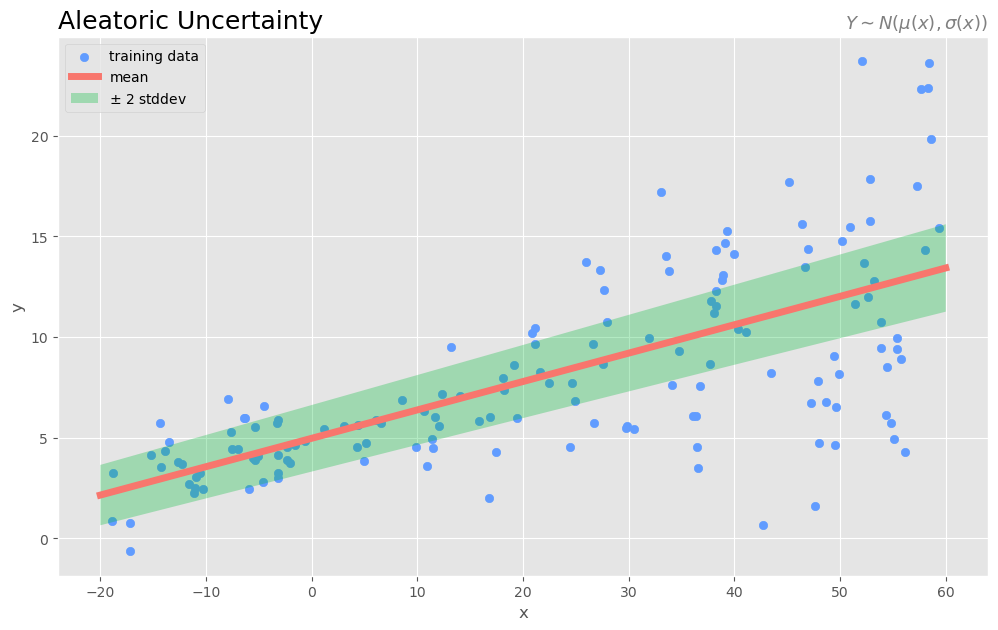

In [10]:
# predict normal distributions for each x
yhat = model_case_2(xs_test)

# get mean and variance
yhat_mean = yhat.mean()
yhat_std = yhat.stddev()

plot_training_data()
plt_left_title("Aleatoric Uncertainty")
plt_right_title("$Y \sim N(\mu (x), \sigma (x))$")
# plot mean
plt.plot(x_domain, yhat_mean, "#F8766D", linewidth=5, label="mean")
# plot 2 stddev from mean
plt.fill_between(x_domain,
                 (yhat_mean + 2 * yhat_std)[:, 0], 
                 (yhat_mean - 2 * yhat_std)[:, 0],
                 facecolor="#00BA38", alpha=0.3,
                 label="$\pm$ 2 stddev")
plt.legend();

# Case 3: Epistemic Uncertainty

We're assuming a linear relationship between $x$ and $y$, and our last two models gave exact estimates of the weights (e.g. $w_0$ and $b_0$). But how certain are we of those _exact_ estimates?

What if we could consider many candidates for the weights all at once? Perhaps we could assume that the weights are normally distributed--the mean weight is our best guess, but we're willing to consider things near it as the true weight too.

Now the weights are Normal distributions, instead of numbers. In order to train the neural network, we use something called variational inference. That's outside the scope of this discussion, but just know that TensorFlow Probability's `DenseVariational` layer handles this step.

Now our model has

- a one-dimensional input layer
- a `DenseVariational` layer, which treats the weights as distributions, rather than numbers
- an output layer that yields a Normal distribution with constant variance

And it has the functional form

$$
f(x) \sim N(Wx + B, 1)
$$

Where $W$ and $B$ are normally-distributed random variables. 

In [11]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.0))
    
    return tfk.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n], 
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1))
    ])

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    
    return tfk.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1.0),
            reinterpreted_batch_ndims=1))
    ])

In [12]:
model_case_3 = tfk.Sequential([
    tfp.layers.DenseVariational(1, 
                            posterior_mean_field, 
                            prior_trainable),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t, scale=1.0)
    )
])

model_case_3.compile(optimizer=tfk.optimizers.Adam(learning_rate=0.01),
                     loss=neg_log_lik)
model_case_3.fit(xs, ys,
                 epochs=1000,
                 verbose=False)

print("Model 3 weights:")
[print(np.squeeze(w.numpy())) for w in model_case_3.weights];

Model 3 weights:
[ 0.13317278  4.82585    -3.8713584  -0.4644979 ]
[0.14557841 4.786414  ]


Each time we call `model_case_3(xs_test)`, it will give us a different answer. This is because the model is sampling from the distributions imposed on the weights.

This means that we need to make predictions multiple times to understand how the distributions on the weights affect the final prediction. In this case we'll take 50 samples, which means there will be 50 guesses as to what the linear relationship between $x$ and $y$ is.

This is called [**epistemic uncertainty**](https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic_uncertainty), which represents the unknown factors in your model, your sensor, etc. 

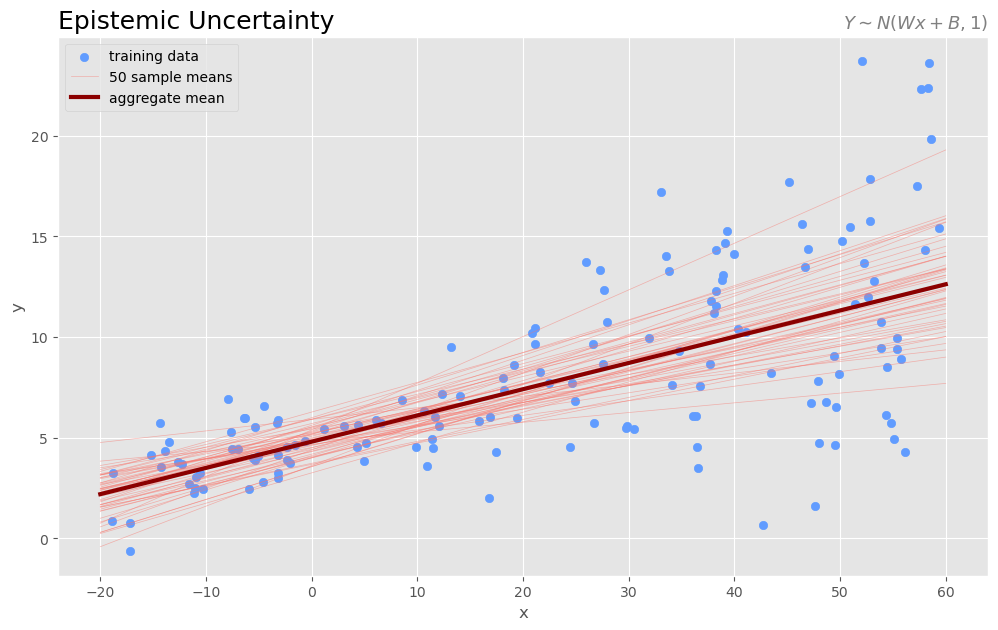

In [13]:
# sample posterior
n_posterior_samples = 50
yhats = [model_case_3(xs_test) for _ in range(n_posterior_samples)]

plot_training_data()
plt_left_title("Epistemic Uncertainty")
plt_right_title("$Y \sim N(W x + B, 1)$")

# plot means for each posterior sample
for i, yhat in enumerate(yhats):
    plt.plot(xs_test, yhat.mean(), 
             '#F8766D', linewidth=0.5, alpha=0.5, 
             label=f"{n_posterior_samples} sample means" if i==0 else None)

# plot overall mean
yhats_mean = sum(yh.mean() for yh in yhats) / len(yhats)
plt.plot(xs_test, yhats_mean, 'darkred', linewidth=3, label="aggregate mean")
plt.legend();

# Case 4: Aleatoric & Epistemic Uncertainty

We can include both types of uncertainty in our model. For each of the models we consider due to epistemic uncertainty, we can incorporate aleatoric uncertainty.

In [14]:
model_case_4 = tfk.Sequential([
    tfp.layers.DenseVariational(2, 
                                posterior_mean_field,
                                prior_trainable),
    tfp.layers.DistributionLambda(partial(normal_scale_uncertainty, softplus_scale=0.01))
])

model_case_4.compile(optimizer=tfk.optimizers.Adam(learning_rate=0.01),
                     loss=neg_log_lik)
model_case_4.fit(xs, ys,
                 epochs=1000,
                 verbose=False)

print("Model 4 weights:")
[print(np.squeeze(w.numpy())) for w in model_case_4.weights];

Model 4 weights:
[ 0.13823536  0.0637027   4.7445903   0.01369894 -3.374934    0.04337644
 -0.84951454 -0.03572116]
[ 0.14815725 -0.06370272  4.715294   -0.01369894]


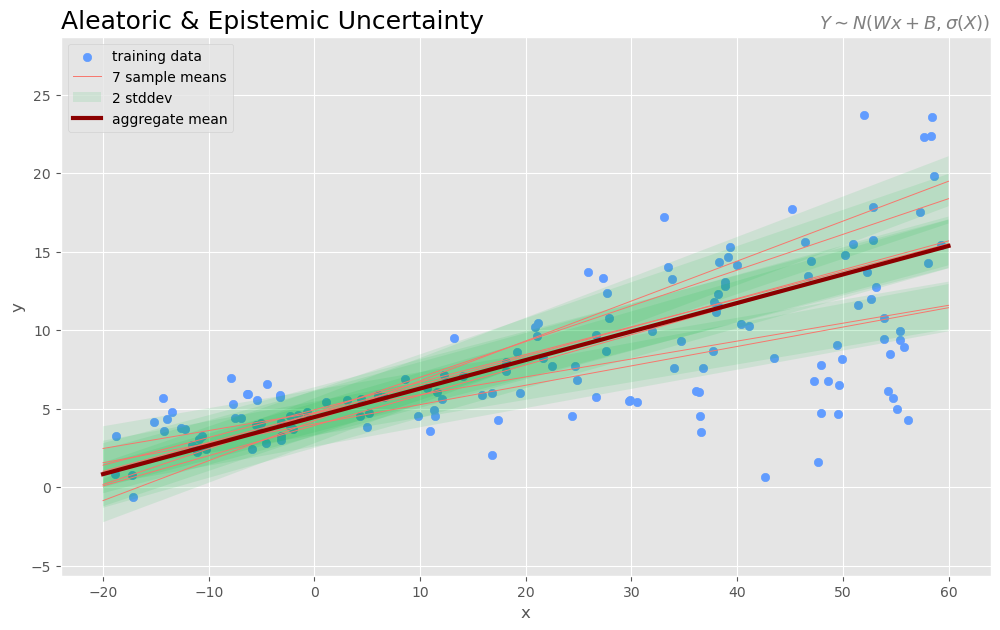

In [15]:
yhats = [model_case_4(xs_test) for _ in range(7)]

plot_training_data()
plt_left_title("Aleatoric & Epistemic Uncertainty")
plt_right_title("$Y \sim N ( W x + B, \sigma(X) )$")
plt.ylim(ys.min() - 5, ys.max() + 5)

# for each posterior sample, plot mean plus/minus 2 std
for i, yhat in enumerate(yhats):
    m = yhat.mean()[:, 0]
    s = yhat.stddev()[:, 0]

    plt.plot(xs_test, m, "#F8766D", linewidth=0.7, 
             label=f"{len(yhats)} sample means" if i==0 else None)
    plt.fill_between(xs_test[:, 0],
                     m - 2 * s, m + 2 * s,
                     facecolor="#00BA38", alpha=0.1,
                     label=f"2 stddev" if i==0 else None)
    
# plot overall mean
yhats_mean = sum(yh.mean() for yh in yhats) / len(yhats)
plt.plot(xs_test, yhats_mean, 'darkred', linewidth=3, label="aggregate mean")

plt.legend();

# Case 5: Functional Uncertainty

In [30]:
class RBFKernelFn(tfk.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        dtype = kwargs.get('dtype', None)
        
        self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name="amplitude"
        )
        self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name="length_scale"
        )
    
    def call(self, x):
        return x
    
    @property
    def kernel(self):
        return tfp_math.psd_kernels.ExponentiatedQuadratic(
            amplitude=tf.nn.softplus(0.1 * self._amplitude),
            length_scale=tf.nn.softplus(5.0 * self._length_scale)
        )

In [31]:
num_inducing_points = 40
inducing_index_points_initializer = np.linspace(*x_range, num=num_inducing_points, dtype=xs.dtype)[..., np.newaxis],

model_case_5 = tfk.Sequential([
    tfk.layers.InputLayer(input_shape=[1], dtype=xs.dtype),
    tfk.layers.Dense(1, 
                     kernel_initializer="ones", 
                     use_bias=False),
    tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(dtype=xs.dtype),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(inducing_index_points_initializer),
        unconstrained_observation_noise_variance_initializer=(tf.constant_initializer(np.array(0.54).astype(xs.dtype)))
    )
])

batch_size = 32

def variational_loss(y, rv_y):
    return rv_y.variational_loss(y, 
                                 kl_weight=np.array(batch_size, xs.dtype) / xs.shape[0])

model_case_5.compile(optimizer=tfk.optimizers.Adam(learning_rate=0.01),
                    loss=variational_loss)
model_case_5.fit(xs, ys,
                 batch_size=batch_size,
                 epochs=800,
                 verbose=False)

/tmp/ipykernel_531921/761427919.py:6: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self._amplitude = self.add_variable(
/tmp/ipykernel_531921/761427919.py:11: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self._length_scale = self.add_variable(


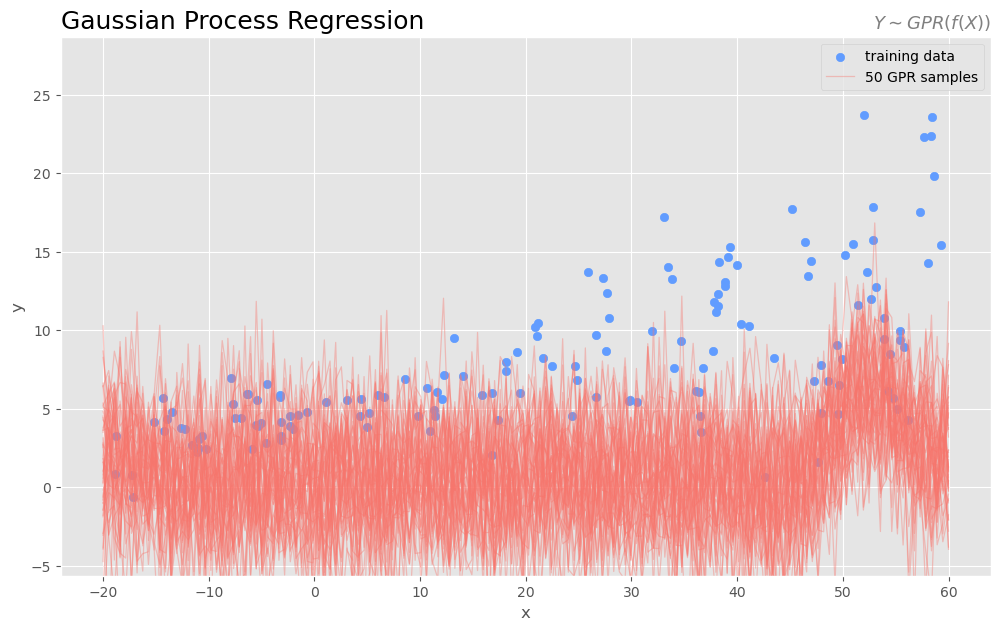

In [21]:
yhats = model_case_5(xs_test)

plot_training_data()
plt_left_title("Gaussian Process Regression")
plt_right_title("$ Y \sim GPR(f(X)) $")
plt.ylim(ys.min() - 5, ys.max() + 5)

n_gpr_samples = 50
for _ in range(n_gpr_samples):
    sample_ = yhats.sample().numpy()[..., 0]
    plt.plot(xs_test, sample_, "#F8766D", linewidth=0.9, alpha=0.4,
             label=f"{n_gpr_samples} GPR samples" if _==0 else None)
    
plt.legend();